In [1]:
import h5py 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import GridSearchCV, StratifiedKFold, KFold

from utils import ChangeRepresentation

#Réduction dimension
from sklearn.manifold import TSNE, MDS, Isomap, LocallyLinearEmbedding, SpectralEmbedding
from sklearn.decomposition import PCA, KernelPCA, TruncatedSVD, NMF, FactorAnalysis, FastICA, LatentDirichletAllocation
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection, johnson_lindenstrauss_min_dim

#Modèle
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Extract Data

In [2]:
f = h5py.File('SG24_dataset.h5', 'r')
f.keys()

<KeysViewHDF5 ['Predictors', 'Target', 'User']>

In [3]:
tmp = f['Predictors']
predictors = np.zeros(tmp.shape)
tmp.read_direct(predictors)
predictors = predictors.T

tmp = f['Target']
target = np.zeros(tmp.shape)
tmp.read_direct(target)
target = target[0]

tmp = f['User']
user = np.zeros(tmp.shape)
tmp.read_direct(user)
user = user.T

print(predictors.shape)
print(target.shape)
print(user.shape)

(2400, 29)
(2400,)
(2400, 1)


# Analyse exploratoire

## Simple Describe

In [23]:
pd.DataFrame(predictors).describe()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,53.669293,-5.698329,0.203902,0.491011,-0.140472,0.164828,-0.149610,129.851667,137.503750,145.390833,...,110.054167,82.854167,103.005417,91.606667,143.834167,109.237083,120.668750,82.562500,137.099167,83.047500
std,41.520634,32.720964,22.393903,0.249192,0.281654,0.690302,0.268272,32.298842,15.895186,31.776834,...,46.031646,20.323427,45.260604,22.685341,53.253552,17.291823,29.802893,48.056139,21.926745,30.394479
min,0.000000,-81.559349,-68.739662,0.000000,-0.855817,-1.000000,-0.789427,1.000000,44.000000,36.000000,...,0.000000,1.000000,1.000000,25.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,-26.450032,-15.801244,0.314152,-0.387735,-0.846747,-0.360048,122.000000,128.000000,121.750000,...,63.000000,71.000000,79.000000,75.000000,92.000000,105.000000,104.000000,49.000000,131.000000,64.000000
50%,70.621365,0.000000,0.000000,0.555695,0.000000,0.471377,-0.062433,128.000000,135.000000,152.000000,...,132.000000,81.000000,114.000000,92.000000,159.000000,106.000000,126.000000,86.000000,141.000000,78.000000
75%,84.528341,0.000000,17.166466,0.691598,0.000000,0.629917,0.000000,134.000000,143.000000,170.000000,...,151.000000,93.000000,134.000000,111.000000,192.000000,107.000000,142.000000,116.000000,149.000000,101.000000
max,127.721718,78.185921,59.903419,0.955188,0.727471,1.000000,0.782390,238.000000,206.000000,207.000000,...,179.000000,170.000000,218.000000,229.000000,248.000000,255.000000,189.000000,216.000000,192.000000,193.000000


In [24]:
Counter(list(target))

Counter({1.0: 100,
         2.0: 100,
         3.0: 100,
         4.0: 100,
         5.0: 100,
         6.0: 100,
         7.0: 100,
         8.0: 100,
         9.0: 100,
         10.0: 100,
         11.0: 100,
         12.0: 100,
         13.0: 100,
         14.0: 100,
         15.0: 100,
         16.0: 100,
         17.0: 100,
         18.0: 100,
         19.0: 100,
         20.0: 100,
         21.0: 100,
         22.0: 100,
         23.0: 100,
         24.0: 100})

In [25]:
Counter(list(user.T[0]))

Counter({1.0: 600,
         2.0: 600,
         3.0: 360,
         4.0: 240,
         5.0: 240,
         6.0: 120,
         7.0: 120,
         8.0: 120})

## Graphiques users & targets

In [4]:
user_target_df = pd.DataFrame({'user':user.T[0], 'target':target})

In [5]:
user_target_df.sample(10)

,user,target
1829,5.0,21.0
1196,2.0,21.0
1696,4.0,10.0
2133,6.0,19.0
410,1.0,21.0
1660,4.0,12.0
1383,3.0,13.0
2198,7.0,8.0
2223,7.0,14.0
716,2.0,8.0


### Nombre d'exemple par utilisateurs

In [6]:
target_by_user = user_target_df.groupby('user').count()

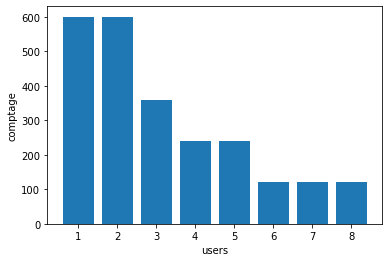

In [29]:
plt.bar(target_by_user.index, target_by_user['target'])
plt.ylabel('comptage')
plt.xlabel('users')

plt.show()

### Nombre d'exemple par utilisateurs avec la répartition des classes par user

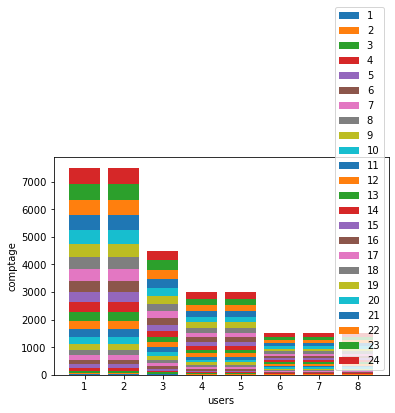

In [117]:
users = [int(u) for u in np.unique(user)]
targets = [int(t) for t in np.unique(target)]

y = []
for t in targets:
    y.append(user_target_df[user_target_df['target']==t].groupby('user').sum()['target'])
    

cum_sum = np.zeros(len(users))

bars = []
for t in targets:
    i=int(t)-1
    bars.append(plt.bar(users, y[i], bottom=cum_sum))
    cum_sum += y[i]
_ = plt.xticks(users, users)

plt.ylabel('comptage')
plt.xlabel('users')

plt.legend(bars, targets)

plt.show()

### Nombre d'exemple par target

In [30]:
user_by_target = user_target_df.groupby('target').count()

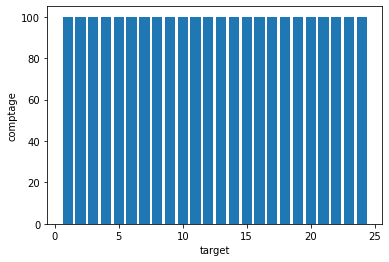

In [31]:
plt.bar(user_by_target.index, user_by_target['user'])
plt.ylabel('comptage')
plt.xlabel('target')

plt.show()

### Nombre d'exemple par target avec la répartition par user

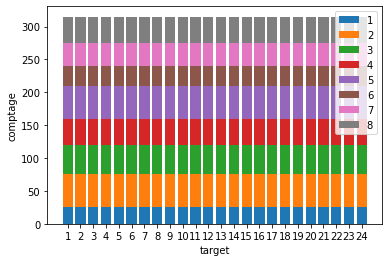

In [118]:
users = [int(u) for u in np.unique(user)]
targets = [int(t) for t in np.unique(target)]


y = []
for u in users:
    y.append(user_target_df[user_target_df['user']==u].groupby('target').sum()['user'])


cum_sum = np.zeros(len(targets))

bars = []
for u in users:
    i=int(u)-1
    bars.append(plt.bar(targets, y[i], bottom=cum_sum))
    cum_sum += y[i]
_ = plt.xticks(targets, targets)

plt.ylabel('comptage')
plt.xlabel('target')

plt.legend(bars, users)

plt.show()

# Pré-traitement des données

Voir la class *ChangeRepresentation* dans le fichier utils.py

In [ ]:
algo = ChangeRepresentation(algo="autoencoder", parameters={})
algo.fit(predictors_norm[:100])
res = algo.transform(predictors_norm[:100])

### Normalisation

#### Normalisation entre 0 et 1

In [4]:
predictors_norm = (predictors-predictors.min(axis=0))/(predictors.max(axis=0)-predictors.min(axis=0))

In [8]:
pd.DataFrame(predictors_norm).describe()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,0.420205,0.474887,0.535929,0.514046,0.451810,0.582414,0.407056,0.543678,0.577184,0.639712,...,0.614828,0.484344,0.470071,0.326503,0.579976,0.426130,0.636536,0.379360,0.714058,0.430298
std,0.325087,0.204832,0.174078,0.260883,0.177892,0.345151,0.170677,0.136282,0.098118,0.185829,...,0.257160,0.120257,0.208574,0.111203,0.214732,0.068078,0.158526,0.223517,0.114202,0.157484
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.344982,0.411514,0.328890,0.295639,0.076626,0.273174,0.510549,0.518519,0.501462,...,0.351955,0.414201,0.359447,0.245098,0.370968,0.409449,0.547872,0.223256,0.682292,0.331606
50%,0.552932,0.510559,0.534344,0.581764,0.540531,0.735688,0.462518,0.535865,0.561728,0.678363,...,0.737430,0.473373,0.520737,0.328431,0.641129,0.413386,0.664894,0.395349,0.734375,0.404145
75%,0.661817,0.510559,0.667787,0.724043,0.540531,0.814959,0.502239,0.561181,0.611111,0.783626,...,0.843575,0.544379,0.612903,0.421569,0.774194,0.417323,0.750000,0.534884,0.776042,0.523316
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Normalisation entre -1 et 1

In [5]:
predictors_norm2 = predictors_norm*2-1

In [12]:
pd.DataFrame(predictors_norm2).describe()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
count,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,...,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000,2400.000000
mean,-0.159590,-0.050225,0.071858,0.028092,-0.096380,0.164828,-0.185888,0.087356,0.154367,0.279425,...,0.229655,-0.031312,-0.059858,-0.346993,0.159953,-0.147740,0.273072,-0.241279,0.428116,-0.139404
std,0.650173,0.409664,0.348156,0.521765,0.355784,0.690302,0.341353,0.272564,0.196237,0.371659,...,0.514320,0.240514,0.417148,0.222405,0.429464,0.136156,0.317052,0.447034,0.228404,0.314969
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-1.000000,-0.310035,-0.176972,-0.342220,-0.408722,-0.846747,-0.453652,0.021097,0.037037,0.002924,...,-0.296089,-0.171598,-0.281106,-0.509804,-0.258065,-0.181102,0.095745,-0.553488,0.364583,-0.336788
50%,0.105863,0.021118,0.068688,0.163529,0.081063,0.471377,-0.074963,0.071730,0.123457,0.356725,...,0.474860,-0.053254,0.041475,-0.343137,0.282258,-0.173228,0.329787,-0.209302,0.468750,-0.191710
75%,0.323633,0.021118,0.335573,0.448086,0.081063,0.629917,0.004477,0.122363,0.222222,0.567251,...,0.687151,0.088757,0.225806,-0.156863,0.548387,-0.165354,0.500000,0.069767,0.552083,0.046632
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Normalisation centrée réduite

In [6]:
predictors_red = (predictors-predictors.mean(axis=0))/predictors.std(axis=0)

In [13]:
pd.DataFrame(predictors_red).describe()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
count,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2400.000000,2.400000e+03,2.400000e+03,2.400000e+03,...,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2.400000e+03,2400.000000
mean,-9.473903e-17,-2.960595e-17,-3.552714e-17,-9.473903e-17,-7.105427e-17,-4.736952e-17,0.000000,2.131628e-16,2.368476e-16,-4.500104e-16,...,1.302662e-16,-2.368476e-16,1.302662e-16,-1.302662e-16,-1.598721e-16,1.421085e-16,-1.125026e-16,1.184238e-17,2.250052e-16,0.000000
std,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208,1.000208e+00,1.000208e+00,1.000208e+00,...,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208e+00,1.000208
min,-1.292863e+00,-2.318906e+00,-3.079317e+00,-1.970823e+00,-2.540330e+00,-1.687770e+00,-2.385451,-3.990190e+00,-5.883746e+00,-3.443189e+00,...,-2.391335e+00,-4.028416e+00,-2.254205e+00,-2.936722e+00,-2.701494e+00,-6.260742e+00,-4.016177e+00,-1.697587e+00,-6.253903e+00,-2.732891
25%,-1.292863e+00,-6.343342e-01,-7.148589e-01,-7.098772e-01,-8.780804e-01,-1.465715e+00,-0.784582,-2.431450e-01,-5.980258e-01,-7.441195e-01,...,-1.022426e+00,-5.833975e-01,-5.304927e-01,-7.321965e-01,-9.735495e-01,-2.450850e-01,-5.594163e-01,-6.985475e-01,-2.782190e-01,-0.626807
50%,4.083657e-01,1.741855e-01,-9.107165e-03,2.596275e-01,4.988436e-01,4.441727e-01,0.325024,-5.734114e-02,-1.575491e-01,2.080303e-01,...,4.768547e-01,-9.125199e-02,2.429679e-01,1.734227e-02,2.848447e-01,-1.872421e-01,1.789209e-01,7.154583e-02,1.779401e-01,-0.166101
75%,7.433769e-01,1.741855e-01,7.576213e-01,8.051164e-01,4.988436e-01,6.738890e-01,0.557796,1.284627e-01,3.458529e-01,7.745987e-01,...,8.897002e-01,4.993227e-01,6.849454e-01,8.550621e-01,9.046508e-01,-1.293993e-01,7.158934e-01,6.959458e-01,5.428673e-01,0.590773
max,1.783881e+00,2.564158e+00,2.666438e+00,1.863119e+00,3.082235e+00,1.210118e+00,3.474803,3.349063e+00,4.310143e+00,1.939212e+00,...,1.498104e+00,4.288843e+00,2.541251e+00,6.057743e+00,1.956443e+00,8.431343e+00,2.293250e+00,2.777279e+00,2.504351e+00,3.618269


## Réduction de dimensions

### ACP

- ACP per user

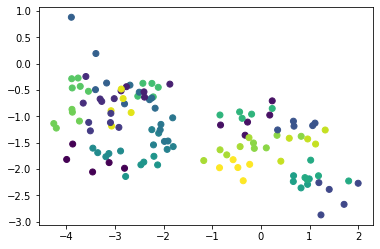

In [40]:
pca1 = PCA(n_components=2)
pca1.fit(predictors_red)
predictors_red_pca = pca1.transform(predictors_red)

num_user = 8

plt.scatter(predictors_red_pca[np.where(user == num_user)[0],0], predictors_red_pca[np.where(user == num_user)[0],1], c=target[np.where(user == num_user)[0]]) # User 3

- ACP cross user

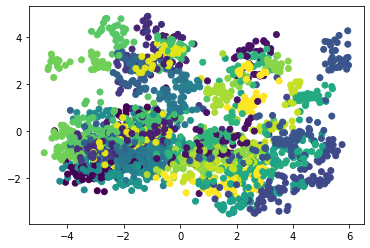

In [45]:
pca = PCA(n_components=2)
pca.fit(predictors_red)
predictors_red_pca = pca.transform(predictors_red)

plt.scatter(predictors_red_pca[:,0], predictors_red_pca[:,1], c=target)

In [46]:
pca = PCA(n_components=2)
pca.fit(predictors-predictors.mean(axis=0))
predictors_cent_pca = pca.transform(predictors-predictors.mean(axis=0))

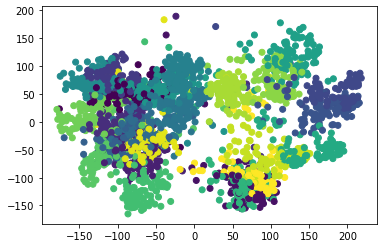

In [47]:
plt.scatter(predictors_cent_pca[:,0], predictors_cent_pca[:,1], c=target)

### NMF

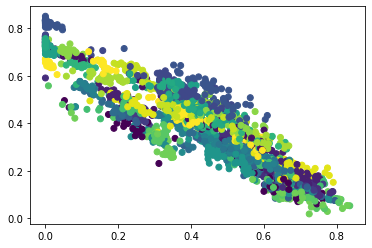

In [59]:
nmf = NMF(n_components=2, init='random')
nmf.fit(predictors_norm)
nmf_predictors = nmf.transform(predictors_norm)
plt.scatter(nmf_predictors[:, 0], nmf_predictors[:, 1], c=target)

### SVD

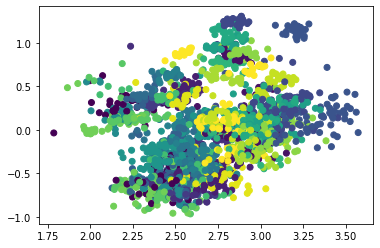

In [57]:
svd = TruncatedSVD(n_components=2)
svd.fit(predictors_norm)
svd_predictors = svd.transform(predictors_norm)
plt.scatter(svd_predictors[:, 0], svd_predictors[:, 1], c=target)

### t-SNE

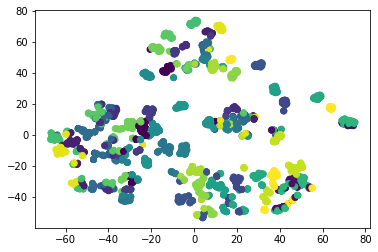

In [52]:
tsne = TSNE(n_components=2, init='pca')
predictors_tsne_pca = tsne.fit_transform(predictors_norm)
plt.scatter(predictors_tsne_pca[:, 0], predictors_tsne_pca[:, 1], c=target)

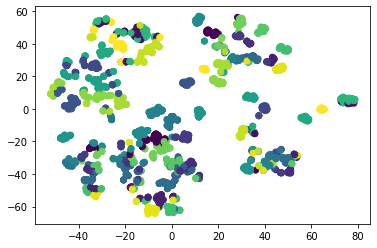

In [53]:
tsne = TSNE(n_components=2, init='random')
predictors_tsne = tsne.fit_transform(predictors_norm)
plt.scatter(predictors_tsne[:, 0], predictors_tsne[:, 1], c=target)

### MDS

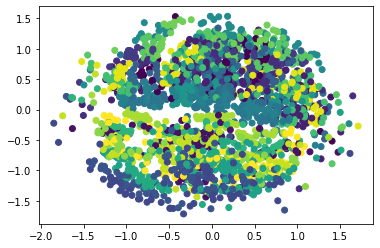

In [55]:
mds = MDS(n_components=2, max_iter=100, n_init=1)
mds_predictors = mds.fit_transform(predictors_norm)
plt.scatter(mds_predictors[:, 0], mds_predictors[:, 1], c=target)

### Autoencoder 

d'après cet article : https://www.researchgate.net/publication/284930266_Auto-Encoder_Based_Dimensionality_Reduction <br/>
La dimension latente ne doit pas etre inférieur à la dimension intrinsèque des données (logique) mais l'optimal semble pouvori etre trouvé vers cette dimension intrasèque. Dans article pour dataset MNIST, dim intra = nbClasse (assez logique puisque les grande caractéristique sont les les classes).<br/><br/>

Pour l'apprentissage d'une représentation optimal, une diension altenten correspondant aux classes semble intéresant

# Visualisation données avec pré-traitement

## Densité des features

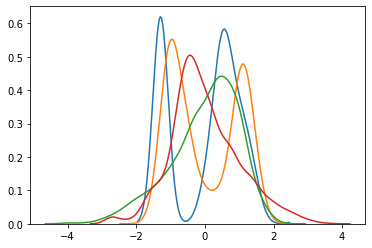

In [21]:
choosen_features = [0,15,25,28]
for feature in choosen_features:
    sns.distplot(predictors_red[:,feature], kde=True, hist=False)

## Variance des users

In [ ]:
#variance pur chaque feature pour chaque user
#variance pour l'ensemble des points consitués par un user (existe? pas plutot matrice de covariance?)

# Taches supervisées

## Choix des modèles et des hyper paramètres à tester

In [7]:
#Very small dataset non randomized just to test the models.
predictors = predictors[:50]
target = target[:50]

In [44]:
# List of models with hyper parameter to test
models = []

# Perceptron
percep = Perceptron()
percep_params = {'alpha' : [0.001, 0.0001]}
models.append((percep, percep_params))

# Knn
knn = KNeighborsClassifier()
knn_params = {'n_neighbors':[3, 5]}
models.append((knn, knn_params))

# LogisticRegression
logicR = LogisticRegression()
logicR_params = {'penalty':["l1", "l2", "elacticnet"], 
                 'C':[1.0, 0.5, 0.1], 
                 'tol':[1e-2, 1e-3, 1e-4]}
models.append((logicR, logicR_params))

# Ridge
ridge = RidgeClassifier()
ridge_params = {'alpha':[1.0, 0.5, 2, 5], 
               'tol':[1e-2, 1e-3, 1e-4]}
models.append((ridge, ridge_params))

# Decision Tree
tree = DecisionTreeClassifier()
tree_params = {'criterion':['gini', 'entropy'],
              'max_depth': [None, 1, 3, 5],
              'max_features':[None, "sqrt"]}
models.append((tree, tree_params))

# Gaussian Classifier
gaussianProc = GaussianProcessClassifier()
gaussianProc_params = {'max_iter_predict':[100, 1000]}
models.append((gaussianProc, gaussianProc_params))

# QA
qa = QuadraticDiscriminantAnalysis()
qa_params = {'tol':[1e-3, 1e-4, 1e-5],
            'reg_param':[0.0, 0.1, 0.5]}
models.append((qa, qa_params))

# SVC
svc = SVC()
svc_params = {'C':[0.5, 1, 2],
             'kernel': ['linear', 'poly', 'rbf'],
             'degree': [2,3,5],
             'gamma': ["scale", "auto"]}
models.append((svc, svc_params))

# Random Forest
randomForest = RandomForestClassifier()
randomForest_params = {'n_estimators':[20, 50, 100, 200],
                       'criterion':['gini', 'entropy'],
                       'max_depth': [None, 1, 3, 5, 10, 50],
                       'max_features':["log2", "sqrt"]
                      }
models.append((randomForest, randomForest_params))

#XGBoost
xgb = XGBClassifier()
xgb_params = {'n_estimators':[50, 100, 200],
             'objective':['multi:softprob'],
             'max_depth':[1,3,5],
             'colsample_bytree':[0.2,0.5,0.8]}
models.append((xgb, xgb_params))

#MLP Classifier
mlp = FeedForwardMLPClassifier()
mlp_params = {'dropout':[0.0, 0.25, 0.5],
             'batchNorm':[False, True],
             'epsi':[1e-3, 1e-4, 1e-5],
              'batch_size':[1, 10, 100],
             'num_epochs':[100]}
models.append((mlp, mlp_params))

In [58]:
class FeedForwardMLPClassifier(nn.Module):
    
    def __init__(self, activation, layers, dropout=0.0, batchNorm=False, epsi=1e-3, num_epochs=10, batch_size=100):
        super().__init__()
        self.act = activation()
        self.layers = []
        self.dropout = nn.Dropout(dropout)
        self.batchNorm = batchNorm
        self.batchNorms = []
        for i in range(len(layers)-1):
            self.layers.append(nn.Linear(layers[i], layers[i+1], bias=True))
            if(batchNorm==True and i>1):
                self.batchNorms.append(nn.BatchNorm1d(layers[i]))
                
        self.epsi = epsi
        self.num_epochs = num_epochs
        self.batch_size = batch_size 
            

        
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if(i<len(self.batchNorms)):
                x = self.batchNorms[i](x)
            x = self.act(x)
            x = self.dropout(x)
        return x
    
    
    def parameters(self):
        parameters = []
        for layer in self.layers:
            parameters.extend(layer.parameters())
        return parameters
    
    
    def fit(self, X, y):
        self.train()
        train_loader = DataLoader(DatasetReds(X, y), shuffle=True, batch_size=self.batch_size)
        
        optimizer = torch.optim.Adam(params=self.parameters(), lr=self.epsi)
        optimizer.zero_grad()

        criterion = nn.CrossEntropyLoss()


        for epoch in range(self.num_epochs):
            
            for data, labels in train_loader:

                optimizer.zero_grad()
                outputs = self.forward(data)
                train_loss = criterion(outputs, labels)

                train_loss.backward()
                optimizer.step()   
        
    
    
    def predict(self, X):
        self.eval()
        with torch.no_grad():
            out = self.forward(X)
            y_test_pred = model(X_batch)
            y_pred_softmax = torch.log_softmax(y_test_pred, dim = 1)
            _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
            return y_pred_tags.numpy()

In [49]:
class ResNet():
    pass

class DenseNet():
    pass

## Decoupage en folds

In [45]:
kfold = KFold(n_splits=2, shuffle=True)
#kfold = StratifiedKFold(n_splits=5, shuffle=True) #Choose statified Kfold

## Application des gridSearchs et Récupérations du meilleur modèle

In [46]:
bestModel = None
bestScore = -np.inf

for model, params in models:
    currentBest = GridSearchCV(model, params, cv=kfold)
    currentBest.fit(predictors, target)
    
    if(currentBest.best_score_>bestScore):
        bestScore = currentBest.best_score_
        bestModel = currentBest.best_estimator_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logi

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
C:\ProgramData\Anaconda3\lib\site-

## Utilisation du meilleur estimator

In [11]:
bestModel.fit(predictors, target)# Train the best model & hyper parameters with all available data (TO CONFIRM)

KNeighborsClassifier(n_neighbors=3)

In [12]:
bestModel.predict(predictors) #Test sur les données d'apprentissage

array([ 1.,  1.,  1., ...,  5., 24.,  7.])

# Taches non-supervisées